In [2]:
pip install Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path
import os
ann_base_path = "/kaggle/input/vizwiz/data/Annotations"
images_tr_path = "/kaggle/input/vizwiz/data/Images/"
images_val_path = "/kaggle/input/vizwiz/data/Images/"
ans_embedded_path = "/kaggle/input/answer-space-embed/answer_embed.pt"
ann_tr_path= str(Path(ann_base_path)/"train.json")
ann_val_path = str(Path(ann_base_path)/"val.json")

In [4]:
import json
import datetime
from collections import Counter
import copy
from Levenshtein import distance
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

In [5]:
import json
import datetime
from collections import Counter
import copy
from Levenshtein import distance
import numpy as np


class VQA:
	def __init__(self, annotation_file=None):
		self.dataset = {}
		self.imgToQA = {}
		if annotation_file != None:
			print( 'loading dataset into memory...')
			time_t = datetime.datetime.utcnow()
			dataset = json.load(open(annotation_file, 'r'))
			print( datetime.datetime.utcnow() - time_t)
			self.dataset = dataset
			self.imgToQA = {x['image']:x for x in dataset}

	def getImgs(self):
		return self.imgToQA.keys()

	def getAnns(self, imgs=[], ansTypes=[]):
		"""
		Get annotations that satisfy given filter conditions. default skips that filter
		:param  imgs (str array): get annotations for given image names
				ansTypes  (str array)   : get annotations for given answer types
		:return: annotations  (dict array)   : dict array of annotations
		"""
		anns = self.dataset

		imgs = imgs if type(imgs) == list else [imgs]
		if len(imgs) != 0:
			anns = [self.imgToQA[img] for img in imgs[0]]

		ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]
		if len(ansTypes) != 0:
			anns = [ann for ann in anns if ann['answer_type'] in ansTypes]
		return anns
    
	def types(self,imgs=[]):
		anns = self.dataset

		imgs = imgs if type(imgs) == list else [imgs]
		if len(imgs) != 0:
			anns = [self.imgToQA[img]['answer_type'] for img in imgs[0]]
		return anns

	def showQA(self, anns):
		"""
		Display the specified annotations.
		:param anns (array of object): annotations to display
		:return: None
		"""
		if len(anns) == 0:
			return 0
		for ann in anns:
			print( "Question: %s"%ann['question'])
			print( "Answer: ")
			print( ' \n'.join([x['answer'] for x in ann['answers']]))
			answers = []
			for x in ann['answers']:
				answers.append(x['answer'])
			final_answer=Counter(answers).most_common()[0][0]
			print( "Most common answer: ",final_answer)

loading dataset into memory...
0:00:00.498014
Question: does this top and these pants look good together?
Answer: 
yes 
yes 
yes 
yes 
yes 
no 
yes 
yes 
yes 
yes
Most common answer:  yes


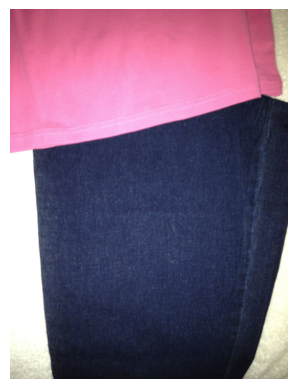

Question: What is this?
Answer: 
guitar 
guitars on wall 
electric guitar 
guitar 
guitar 
i see 3 guitars hanging on wall 
guitar 
guitar 
guitar 
guitar
Most common answer:  guitar


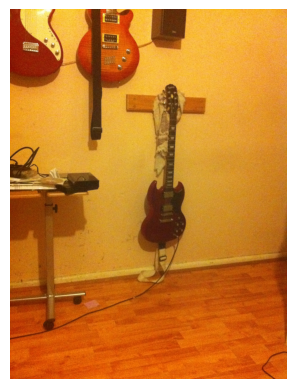

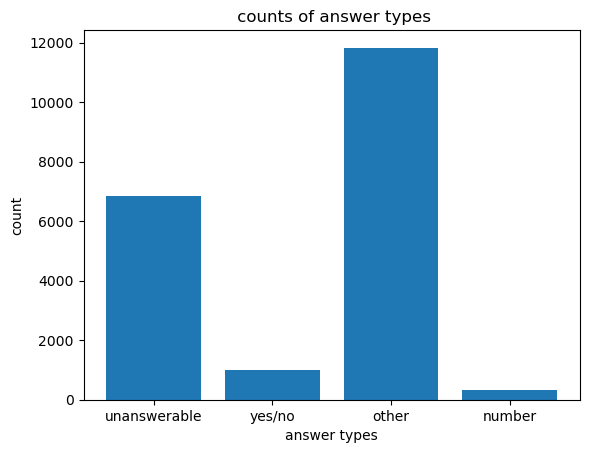

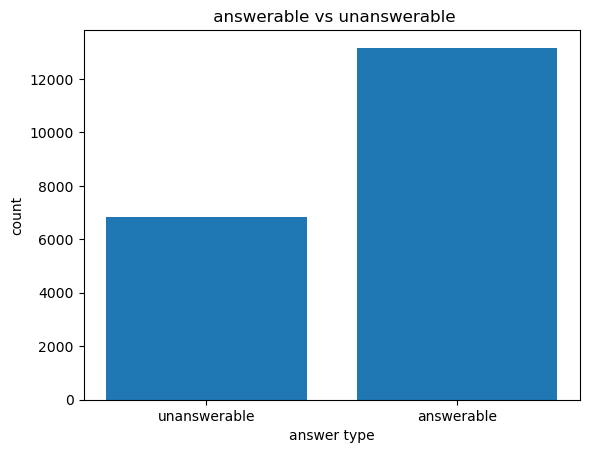

In [6]:
#analysis
import random
import skimage.io as io
import matplotlib.pyplot as plt
import os
import seaborn as sns

dataDir='/kaggle/input/vizwiz/data/'
split = 'train'
annFile='%s/Annotations/%s.json'%(dataDir, split)
imgDir = '%s/Images/' %dataDir
vqa=VQA(annFile)
anns = vqa.getAnns(ansTypes='yes/no');   
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgFilename = randomAnn['image']
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()
histogram_1={}
histogram_2={}
imgs = vqa.getImgs()
anns = vqa.getAnns(imgs=imgs)
types=vqa.types(imgs=imgs)
histogram_1['unanswerable']=types.count('unanswerable')
histogram_1['yes/no']=types.count('yes/no')
histogram_1['other']=types.count('other')
histogram_1['number']=types.count('number')
histogram_2['unanswerable']=types.count('unanswerable')
histogram_2['answerable']=types.count('number')+types.count('other')+types.count('yes/no')
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])  
imgFilename = randomAnn['image']
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()
bin_titles_1 = list(histogram_1.keys())
bin_values_1 = list(histogram_1.values())
plt.bar(bin_titles_1, bin_values_1)
plt.title(' counts of answer types')
plt.xlabel('answer types')
plt.ylabel('count')
plt.show()
bin_titles_2 = list(histogram_2.keys())
bin_values_2 = list(histogram_2.values())
plt.bar(bin_titles_2, bin_values_2)
plt.title(' answerable vs unanswerable')
plt.xlabel('answer type')
plt.ylabel('count')
# Display the plot
plt.show()

In [7]:
import json
import datetime
import pandas as pd
from collections import Counter

class VQAData:
    def __init__(self, annotation_fp, image_base_path):
        # Read in json file as pd.dataframe
        self.df = pd.read_json(annotation_fp,orient="records")
        print("Read in file: {}".format(annotation_fp))
        print("File has shape: {}".format(self.df.shape))
        
        def most_common(lst):
            data = Counter(lst)
            return max(lst, key=data.get)
        
        self.df["max_answer"] = self.df["answers"].apply(lambda row:most_common([ans["answer"] for ans in row]))
        self.df["max_answer_confidence"] = self.df["answers"].apply(lambda row:most_common([ans["answer_confidence"] for ans in row]))
        self.df["answer_list"] = self.df["answers"].apply(lambda row:[ans["answer"] for ans in row])
        image_base_path = Path(image_base_path)
        self.df["image_path"] = self.df["image"].apply(lambda row:str(image_base_path/row))

        
    def get_df(self,fields=["image_path","question","max_answer"], answer_type=None):
        return(self.df[fields])
    
def count(lst):
            data = Counter(lst)
            return data


def final_df(train):
        df_2 = pd.DataFrame()
        df_2['question'] = train['question']
        df_2['answers'] = train['answer_list']
        df_2['counter'] = df_2["answers"].apply(lambda row:count([ans for ans in row]))
        return df_2

In [8]:
vqa_train = VQAData(ann_tr_path,images_tr_path)
vqa_val = VQAData(ann_val_path,images_val_path)
df_train = vqa_train.get_df(fields=["image_path","question","max_answer","answer_list","answer_type"])
df_val = vqa_val.get_df(fields=["image_path","question","max_answer","answer_list","answer_type"])

Read in file: /kaggle/input/vizwiz/data/Annotations/train.json
File has shape: (20000, 5)
Read in file: /kaggle/input/vizwiz/data/Annotations/val.json
File has shape: (3173, 5)


In [9]:
df_train.head()

,image_path,question,max_answer,answer_list,answer_type
0,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What's the name of this product?,basil leaves,"[basil leaves, basil leaves, basil, basil, bas...",other
1,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,Can you tell me what is in this can please?,coca cola,"[soda, coca cola, coca cola, unsuitable, unsui...",other
2,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,Is this enchilada sauce or is this tomatoes? ...,tomatoes,"[these tomatoes not enchilada sauce, tomatoes,...",other
3,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is the captcha on this screenshot?,t36m,"[t36m, t36m, t36m, t 3 6 m, t36m, t36m, t36m, ...",other
4,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is this item?,solar garden light,"[solar garden light, solar garden light, solar...",other


In [10]:
df_train.loc[df_train['question'].str.contains('color',case=False), 'answer_type'] = 'color'
df_train.loc[df_train['max_answer'].str.contains('yes',case=False), 'answer_type'] = 'yes'
df_train.loc[df_train['max_answer'].str.contains('no',case=False), 'answer_type'] = 'no'
df_train.loc[df_train['max_answer'] == 'unsuitable', 'answer_type'] = 'unsuitable'
df_train.loc[df_train['max_answer'] == 'unanswerable', 'answer_type'] = 'unanswerable'
df_train.loc[df_train['answer_type'] == 'yes/no', 'answer_type'] = 'other'
df_val.loc[df_val['question'].str.contains('color',case=False), 'answer_type'] = 'color'
df_val.loc[df_val['max_answer'].str.contains('yes',case=False), 'answer_type'] = 'yes'
df_val.loc[df_val['max_answer'].str.contains('no',case=False), 'answer_type'] = 'no'
df_val.loc[df_val['max_answer'] == 'unsuitable', 'answer_type'] = 'unsuitable'
df_val.loc[df_val['max_answer'] == 'unanswerable', 'answer_type'] = 'unanswerable'
df_val.loc[df_val['answer_type'] == 'yes/no', 'answer_type'] = 'other'

/tmp/ipykernel_28/4111858446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[df_train['question'].str.contains('color',case=False), 'answer_type'] = 'color'
/tmp/ipykernel_28/4111858446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[df_train['max_answer'].str.contains('yes',case=False), 'answer_type'] = 'yes'
/tmp/ipykernel_28/4111858446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc

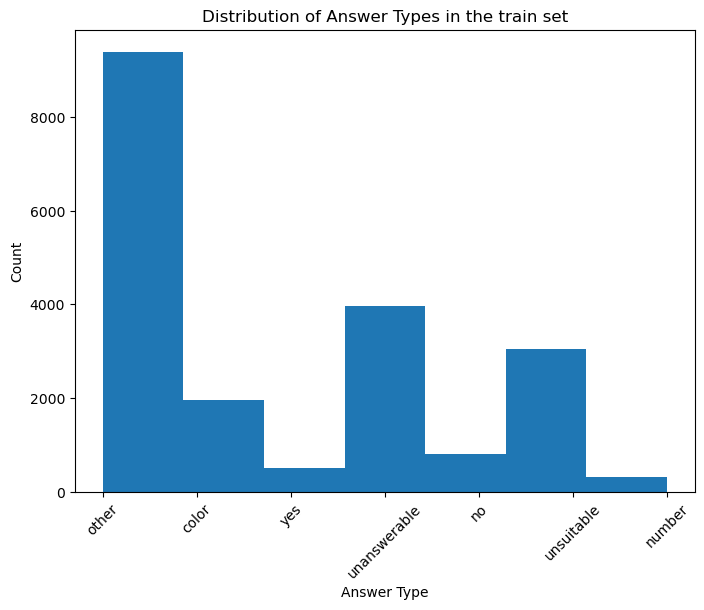

In [11]:
unique_answer_types = df_train['answer_type'].unique()
plt.figure(figsize=(8, 6))
plt.hist(df_train['answer_type'], bins=len(unique_answer_types))
plt.xlabel('Answer Type')
plt.ylabel('Count')
plt.title('Distribution of Answer Types in the train set')
plt.xticks(rotation=45)
plt.show()

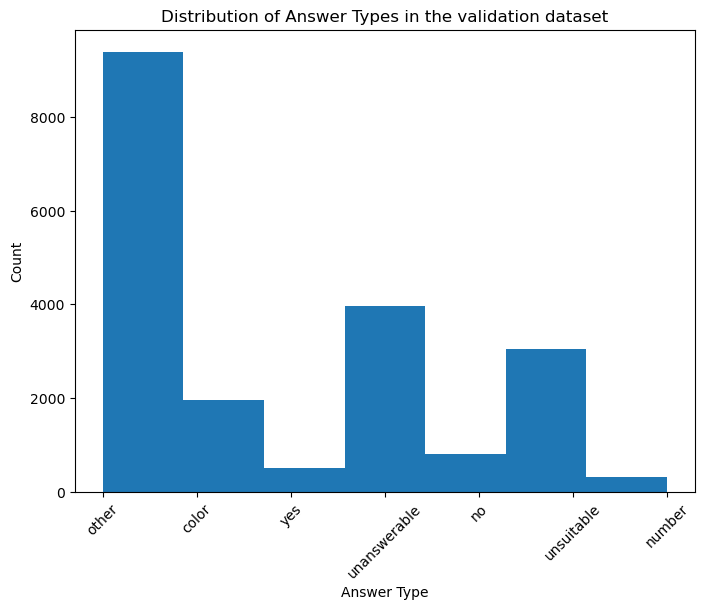

In [12]:
unique_answer_types = df_val['answer_type'].unique()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_train['answer_type'], bins=len(unique_answer_types))
plt.xlabel('Answer Type')
plt.ylabel('Count')
plt.title('Distribution of Answer Types in the validation dataset')
plt.xticks(rotation=45)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_train, test_size=0.05, random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)

(19000, 5)
(1000, 5)


In [15]:
all_answers_list = X_train['answer_list'].explode().tolist()
ans_counts = Counter(all_answers_list)#Counter for each answer in the dataset globally.

In [16]:
df_counted = final_df(X_train)
df_counted = df_counted.reset_index()
index = list(df_counted.index)
vocab = []
labels = []

for i in df_counted.index:
    mydict = df_counted.loc[i, 'counter']
    keys = [k for k, v in mydict.items() if float(v) == max(df_counted.loc[i, 'counter'].values())]
    
    if len(keys) > 1:
        maxi = 0
        key_final = [0]
        
        for key in keys:
            if ans_counts[key] > maxi:
                maxi = ans_counts[key]
                key_final.clear()
                key_final.append(key)
            elif ans_counts[key] == maxi:
                key_final.append(key)
        
        if len(key_final) > 2:
            Matrix = np.zeros((len(key_final), len(key_final)), dtype=np.int)
            
            for j in range(len(key_final)):
                for k in range(len(key_final)):
                    Matrix[j, k] = distance(key_final[j], key_final[k])
            
            min_sum = np.amin(np.sum(Matrix, axis=0))
            min_index = np.where(np.sum(Matrix, axis=0) == min_sum)
            vocab.append(key_final[min_index[0][0]])
            labels.append(key_final[min_index[0][0]])
        else:
            vocab.append(key_final[0])
            labels.append(key_final[0])
    else:
        vocab.append(keys[0])
        labels.append(keys[0])


/tmp/ipykernel_28/1722541222.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Matrix = np.zeros((len(key_final), len(key_final)), dtype=np.int)


In [17]:
df_counted_val = final_df(df_val)
df_counted_val = df_counted_val.reset_index()
index = list(df_counted_val.index)
labels_val = []

for i in df_counted_val.index:
    mydict = df_counted_val.loc[i, 'counter']
    keys = [k for k, v in mydict.items() if float(v) == max(df_counted_val.loc[i, 'counter'].values())]
    
    if len(keys) > 1:
        maxi = 0
        key_final = []
        
        for key in keys:
            if ans_counts[key] > maxi:
                maxi = ans_counts[key]
                key_final.clear()
                key_final.append(key)
            elif ans_counts[key] == maxi:
                key_final.append(key)
        
        if len(key_final) > 2:
            Matrix = np.zeros((len(key_final), len(key_final)), dtype=np.int)
            
            for j in range(len(key_final)):
                for k in range(len(key_final)):
                    Matrix[j, k] = distance(key_final[j], key_final[k])
            
            min_sum = np.amin(np.sum(Matrix, axis=0))
            min_index = np.where(np.sum(Matrix, axis=0) == min_sum)
            labels_val.append(key_final[min_index[0][0]])
        else:
            labels_val.append(key_final[0])
    else:
        labels_val.append(keys[0])


/tmp/ipykernel_28/2017617283.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Matrix = np.zeros((len(key_final), len(key_final)), dtype=np.int)


In [18]:
df_counted = final_df(X_test)
df_counted = df_counted.reset_index()
index = list(df_counted.index)
vocab_test = []
labels_test = []

for i in df_counted.index:
    mydict = df_counted.loc[i, 'counter']
    keys = [k for k, v in mydict.items() if float(v) == max(df_counted.loc[i, 'counter'].values())]
    
    if len(keys) > 1:
        maxi = 0
        key_final = ['']
        
        for key in keys:
            if ans_counts[key] > maxi:
                maxi = ans_counts[key]
                key_final.clear()
                key_final.append(key)
            elif ans_counts[key] == maxi:
                key_final.append(key)
        
        if len(key_final) > 2:
            Matrix = np.zeros((len(key_final), len(key_final)), dtype=np.int64)
            
            for j in range(len(key_final)):
                for k in range(len(key_final)):
                    Matrix[j, k] = distance(key_final[j], key_final[k])
            
            min_sum = np.amin(np.sum(Matrix, axis=0))
            min_index = np.where(np.sum(Matrix, axis=0) == min_sum)
            vocab_test.append(key_final[min_index[0][0]])
            labels_test.append(key_final[min_index[0][0]])
        else:
            vocab_test.append(key_final[0])
            labels_test.append(key_final[0])
    else:
        vocab_test.append(keys[0])
        labels_test.append(keys[0])


In [19]:
len(labels_test)

1000

In [20]:
vocab = set(vocab)
len(vocab)

4687

In [21]:
answer_mapping = pd.DataFrame({'answer': list(vocab),
                                  'class_id': range(0, len(vocab) )})
types_mapping = {"unanswerable": 0,
                             "unsuitable": 1,
                             "yes": 2,
                             "no": 3,
                             "number": 4,
                             "color": 5,
                             "other": 6}

In [22]:
answer_mapping[answer_mapping['answer'] == 'unsuitable']

,answer,class_id
3886,unsuitable,3886


In [23]:
df_counted.head()

,index,question,answers,counter
0,10650,What is this?,"[cold medicine, loratadine d, sunmark, ioratad...","{'cold medicine': 1, 'loratadine d': 2, 'sunma..."
1,2041,"Sorry to trouble you, but on this frozen dinne...","[puncture film 2 to 3 times, leave film intact...","{'puncture film 2 to 3 times': 1, 'leave film ..."
2,8668,What is on the screen?,"[microsoft corporation, progress counter, phil...","{'microsoft corporation': 3, 'progress counter..."
3,1114,What is this?,"[macbook, mac computer, mac laptop, mac, lapto...","{'macbook': 1, 'mac computer': 1, 'mac laptop'..."
4,13902,what is this is can?,"[soup, campbells soup, soup, campbells chicken...","{'soup': 6, 'campbells soup': 1, 'campbells ch..."


In [24]:
X_train_new = X_train[['image_path','question']]
X_test_new = X_test[['image_path','question']]
X_val_new = df_val[['image_path','question']]

In [25]:
train_ans_types = pd.DataFrame(X_train['answer_type'])
test_ans_types = pd.DataFrame(X_test['answer_type'])
val_ans_types = pd.DataFrame(df_val['answer_type'])

In [26]:
ans_type_train = X_train[['answer_type']]
ans_type_train = ans_type_train.reset_index()
ans_type_train = ans_type_train.drop('index', axis=1)
answers_train = pd.DataFrame(labels, columns=['max_answer'])
labels_train = pd.concat([ans_type_train, answers_train], axis=1, join='inner')

ans_type_test = X_test[['answer_type']]
ans_type_test = ans_type_test.reset_index()
ans_type_test = ans_type_test.drop('index', axis=1)
labels_test = X_test[['max_answer']].reset_index().drop('index', axis=1)
types_test = pd.DataFrame(labels_test, columns=['max_answer'])
labels_test = pd.concat([ans_type_test, types_test], axis=1, join='inner')

ans_type_val = df_val[['answer_type']]
ans_type_val = ans_type_val.reset_index()
ans_type_val = ans_type_val.drop('index', axis=1)
answers_val = pd.DataFrame(labels_val, columns=['max_answer'])
labels_val = pd.concat([ans_type_val, answers_val], axis=1, join='inner')


In [163]:
import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tf
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn

class VQA_model(nn.Module):
    def __init__(self):
        super().__init__()

        n_classes = 4687
        n_answer_types = 7
        input_size = 2048
        self.norm1 = nn.LayerNorm(input_size)
        self.drop1 = nn.Dropout(0.5)
        self.linear_after_concat = nn.Linear(input_size, 512)

        self.norm_answer_branch = nn.LayerNorm(512)
        self.dropout_answer_branch = nn.Dropout(0.5)
        self.linear_answer_branch = nn.Linear(512, n_classes)

        self.linear1_answer_type_branch = nn.Linear(512, n_answer_types)
        self.linear2_answer_type_branch = nn.Linear(n_answer_types, n_classes)
        self.sig = nn.Sigmoid()

    def forward(self, image_features, question_features):
        features = torch.cat((image_features.float(), question_features.float()), dim=-1)

        x = self.norm1(features)
        x = self.drop1(x)
        x = self.linear_after_concat(x)

        auxilary = self.linear1_answer_type_branch(x)
        answer_type_gate = self.linear2_answer_type_branch(auxilary)
        answer_type_gate = self.sig(answer_type_gate)

        x = self.norm_answer_branch(x)
        x = self.dropout_answer_branch(x)
        out_answer = self.linear_answer_branch(x)

        final_output = out_answer * answer_type_gate
        final_output = final_output.permute(1, 0, 2)
        final_output = torch.squeeze(final_output, dim=0)

        return final_output, auxilary

model2 = VQA_model()

In [28]:
X_train_new = X_train_new.reset_index()
X_train_new.drop('index',inplace=True, axis=1)

In [29]:
X_val_new_df.head()

NameError: name 'X_val_new_df' is not defined

In [ ]:
%%capture
import sys
!cp -r ../input/openai-clip/CLIP/CLIP-main /tmp/
!gzip -c /tmp/CLIP-main/clip/bpe_simple_vocab_16e6.txt > /tmp/CLIP-main/clip/bpe_simple_vocab_16e6.txt.gz
sys.path.append('/tmp/CLIP-main')

!pip install ../input/openai-clip/ftfy-5.9/ftfy-5.9 \
             ../input/openai-clip/torch-1.7.1+cu110-cp37-cp37m-linux_x86_64.whl \
             ../input/openai-clip/torchvision-0.8.2+cu110-cp37-cp37m-linux_x86_64.whl \
             ../input/faiss-163/faiss_gpu-1.6.3-cp37-cp37m-manylinux2010_x86_64.whl

In [30]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-arpu_8ih
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-arpu_8ih
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=903ca338a6eb662279914a1d5c369b07b04f2fe8d9bf483a2ea4ac1548a07922
  Stored in directory: /tmp/pip-ephem-wheel-cache-ao9a6182/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [31]:
import clip
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
clip_model, preprocess = clip.load('RN50x64', device=device)

100%|█████████████████████████████████████| 1.26G/1.26G [00:21<00:00, 63.8MiB/s]


In [32]:
from tqdm import tqdm

def preprocess(df, labels, clip_model, transform, answer_mapping, types_mapping, test=False):
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing images and questions"):
        img_path = row['image_path']
        question = row['question']

        img = Image.open(img_path, mode='r').resize((clip_model.visual.input_resolution,clip_model.visual.input_resolution))
        img = np.array(img)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        img = img.unsqueeze(dim=0)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        img = img.to(device)

        question_tokens = clip.tokenize(question, truncate=True)
        question_tokens = question_tokens.to(device)

        with torch.no_grad():
            img_encoded = clip_model.encode_image(img)
            question_encoded = clip_model.encode_text(question_tokens)

        df.at[index, 'image_features'] = img_encoded
        df.at[index, 'question_features'] = question_encoded

        del img
        del question_tokens
        torch.cuda.empty_cache()

    return df


In [154]:
class dataset(Dataset):
    def __init__(self, df, labels, transform, answer_mapping, types_mapping,test=False):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.answer_mapping = answer_mapping
        self.types_mapping = types_mapping
        self.test = test
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        try:
            img_encoded = self.df['image_features'][index] 
            question_encoded = self.df['question_features'][index] 
            answer_type = self.labels['answer_type'][index]
            answer = self.labels['max_answer'][index]
    #         print(f"image: {img_encoded}question:{question_encoded} answer_type: {answer_type} answer: {answer}")
            if(self.test):
                return {'img_features' :img_encoded,'question_features':question_encoded}
            else:
                ans_model = self.answer_mapping.index[self.answer_mapping['answer'] == answer][0]
                ansType_model=self.types_mapping[answer_type]
                return {'img_features' : img_encoded,'question_features':question_encoded, 'answer':ans_model, 'answer_type':ansType_model}
        except Exception as e:
            from pdb import set_trace

In [34]:
img_path = X_train_new['image_path'][0]
img = Image.open(img_path, mode='r').resize((clip_model.visual.input_resolution,clip_model.visual.input_resolution))
#img = self.transform(img)
img = np.array(img)
img = torch.from_numpy(img)
img=img.permute(2,0,1)
img = img.unsqueeze(dim=0)
img.shape

torch.Size([1, 3, 448, 448])

In [35]:
X_train_new['image_features']=None 
X_train_new['question_features']=None 

In [36]:
X_train_new.head()

,image_path,question,image_features,question_features
0,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What color is this banana hair clip?,None,None
1,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,Can you describe this picture?,None,None
2,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What's the brand of this shampoo? Thank you.,None,None
3,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is this?,None,None
4,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What color is this?,None,None


In [37]:
X_train_new_df=preprocess(X_train_new, labels_train, clip_model, None, answer_mapping = answer_mapping, types_mapping = types_mapping)

Processing images and questions: 100%|██████████| 19000/19000 [46:54<00:00,  6.75it/s] 


In [38]:
X_val_new['image_features']=None 
X_val_new['question_features']=None 

/tmp/ipykernel_28/3070080700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_new['image_features']=None
/tmp/ipykernel_28/3070080700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_new['question_features']=None


In [39]:
X_val_new.head()

,image_path,question,image_features,question_features
0,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What's this?,None,None
1,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,None,None
2,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,None,None
3,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,None,None
4,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What does it say on this card?,None,None


In [40]:
X_val_new.shape

(3173, 4)

In [111]:
labels_test.head(-20)

,answer_type,max_answer
0,other,loratadine d
1,other,puncture
2,other,microsoft corporation
3,other,apple laptop
4,other,soup
...,...,...
975,unsuitable,unsuitable
976,other,variety puzzles
977,unsuitable,unsuitable
978,other,computer mointer


In [42]:
X_val_new_df=preprocess(X_val_new, labels_val, clip_model, None, answer_mapping = answer_mapping, types_mapping = types_mapping)

Processing images and questions: 100%|██████████| 3173/3173 [07:45<00:00,  6.82it/s]


In [43]:
X_test_new['image_features']=None 
X_test_new['question_features']=None 

/tmp/ipykernel_28/4181090910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new['image_features']=None
/tmp/ipykernel_28/4181090910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new['question_features']=None


In [44]:
X_test_new = X_test_new.reset_index()
X_test_new.drop('index',inplace=True, axis=1)

In [45]:
X_test_new.drop('level_0',inplace=True, axis=1)

KeyError: "['level_0'] not found in axis"

In [48]:
X_test_new_df.head()

,image_path,question,image_features,question_features
0,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is this?,"[[tensor(-50.2500, device='cuda:0', dtype=torc...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
1,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,"Sorry to trouble you, but on this frozen dinne...","[[tensor(0.6011, device='cuda:0', dtype=torch....","[[tensor(0.1578, device='cuda:0', dtype=torch...."
2,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is on the screen?,"[[tensor(-0.3396, device='cuda:0', dtype=torch...","[[tensor(0.5049, device='cuda:0', dtype=torch...."
3,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is this?,"[[tensor(-5.4688, device='cuda:0', dtype=torch...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
4,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,what is this is can?,"[[tensor(6.7656, device='cuda:0', dtype=torch....","[[tensor(1.0400, device='cuda:0', dtype=torch...."


In [47]:
X_test_new_df=preprocess(X_test_new, labels_test, clip_model, None, answer_mapping = answer_mapping, types_mapping = types_mapping)

Processing images and questions: 100%|██████████| 1000/1000 [02:26<00:00,  6.85it/s]


In [141]:
type(X_val_new_df['image_features'][10])

torch.Tensor

In [135]:
labels_val.isnull().sum()

answer_type    0
max_answer     0
dtype: int64

In [91]:
for index, row in X_val_new_df.iterrows():
    tensor = row['image_features']
    reshaped_tensor = tensor.reshape(1, 1024)
    X_val_new_df.at[index, 'image_features'] = reshaped_tensor

In [155]:
ds_train = dataset(X_train_new_df, labels_train, None, answer_mapping = answer_mapping, types_mapping = types_mapping)
loader_train = DataLoader(dataset=ds_train, batch_size=2, shuffle=True)

In [144]:
count=0
for element in ds_val:
    if element is None:
        count+=1
#         print("Dataset contains a None value.")
#         break
print(count)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_28/1068170972.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1287, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1140, in structured_traceback
    formatted_exception = self.format_exce

In [158]:
# with tqdm(loader_val) as tepoch:
#     for batch in tepoch:
# #         first_element = batch["img_features"]
#         print(batch["img_features"].shape)
# #         print(first_element)
with tqdm(loader_val) as tepoch:
    
    for batch in tepoch:
        print(batch["img_features"].shape)
        break
    

  0%|          | 0/3173 [00:00<?, ?it/s]

torch.Size([1, 1, 1024])


In [156]:
ds_val = dataset(X_val_new_df, labels_val, None, answer_mapping = answer_mapping, types_mapping = types_mapping)
loader_val = DataLoader(dataset=ds_val, batch_size=1, shuffle=False,num_workers=0)

In [150]:
with tqdm(loader_test) as tepoch:
    for batch in tepoch:
#         first_element = batch["img_features"]
        print(batch["img_features"].shape)
#         print(first_element)

  0%|          | 2/1000 [00:00<00:10, 92.11it/s]

torch.Size([1, 1, 1024])
torch.Size([1, 1, 1024])


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [77]:
len(loader_train)

9500

In [85]:
len(loader_val)

3173

In [160]:
ds_test = dataset(X_test_new_df, labels_test, None, answer_mapping = answer_mapping, types_mapping = types_mapping)
loader_test = DataLoader(dataset=ds_test, batch_size=1, shuffle=True)

In [161]:
print("Size of X_val_new_df:", len(X_val_new_df))
print("Size of labels_val:", len(labels_val))
print("Length of loader_val:", len(loader_val))

Size of X_val_new_df: 3173
Size of labels_val: 3173
Length of loader_val: 3173


In [57]:
X_train_new_df.head()

,image_path,question,image_features,question_features
0,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What color is this banana hair clip?,"[[tensor(-3.2676, device='cuda:0', dtype=torch...","[[tensor(-0.2383, device='cuda:0', dtype=torch..."
1,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,Can you describe this picture?,"[[tensor(-20.3906, device='cuda:0', dtype=torc...","[[tensor(0.4268, device='cuda:0', dtype=torch...."
2,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What's the brand of this shampoo? Thank you.,"[[tensor(-32.6250, device='cuda:0', dtype=torc...","[[tensor(-0.0730, device='cuda:0', dtype=torch..."
3,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What is this?,"[[tensor(-1.4707, device='cuda:0', dtype=torch...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
4,/kaggle/input/vizwiz/data/Images/VizWiz_train_...,What color is this?,"[[tensor(-5.3867, device='cuda:0', dtype=torch...","[[tensor(0.1700, device='cuda:0', dtype=torch...."


In [58]:
X_val_new_df.head(10)

,image_path,question,image_features,question_features
0,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What's this?,"[[tensor(-8.1172, device='cuda:0', dtype=torch...","[[tensor(0.3931, device='cuda:0', dtype=torch...."
1,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,"[[tensor(-16.6875, device='cuda:0', dtype=torc...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
2,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,"[[tensor(-48.0625, device='cuda:0', dtype=torc...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
3,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,"[[tensor(1.5361, device='cuda:0', dtype=torch....","[[tensor(0.4104, device='cuda:0', dtype=torch...."
4,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What does it say on this card?,"[[tensor(-6.6367, device='cuda:0', dtype=torch...","[[tensor(0.4019, device='cuda:0', dtype=torch...."
5,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,"[[tensor(-12.8828, device='cuda:0', dtype=torc...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
6,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,Where is this play?,"[[tensor(-14.9219, device='cuda:0', dtype=torc...","[[tensor(0.1853, device='cuda:0', dtype=torch...."
7,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What kind of pastries are these?,"[[tensor(-22.3906, device='cuda:0', dtype=torc...","[[tensor(0.2952, device='cuda:0', dtype=torch...."
8,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,"[[tensor(-74.9375, device='cuda:0', dtype=torc...","[[tensor(0.4104, device='cuda:0', dtype=torch...."
9,/kaggle/input/vizwiz/data/Images/VizWiz_val_00...,What is this?,"[[tensor(-26.8125, device='cuda:0', dtype=torc...","[[tensor(0.4104, device='cuda:0', dtype=torch...."


In [104]:
ds_train

In [ ]:
# Training loop
! CUDA_LAUNCH_BLOCKING=1.
# model2.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.00005)
num_epochs  = 5
min_valid_loss = np.inf
# Training loop
model2.train() 
for epoch in range(num_epochs):
    train_loss_answer = 0.0
    train_loss_answer_type = 0.0
    train_total = 0
    train_correct_answer = 0
    train_correct_answer_type = 0
    
    with tqdm(loader_train, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            images = batch['img_features']
            questions = batch['question_features']
            answer = batch['answer']
            answers_types = batch['answer_type']
            answer = answer.type(torch.LongTensor)
            answers_types = answers_types.type(torch.LongTensor)
            
            images = images.to(device)
            questions = questions.to(device)
            answer = answer.to(device)
            answers_types = answers_types.to(device)

            # Forward pass
            with torch.autocast('cuda'):
                outputs, aux = model2(images, questions)
                aux = aux[:, -1]
    
                outputs -= outputs.min(1, keepdim=True)[0]
                outputs /= outputs.max(1, keepdim=True)[0]
            
            # Loss calculation
            loss_answer = criterion(outputs, answer)
            loss_answer_type = criterion(aux, answers_types)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss_answer.backward(retain_graph=True)
            loss_answer_type.backward(retain_graph=True)
            optimizer.step()
            
            train_loss_answer += loss_answer.item()
            train_loss_answer_type += loss_answer_type.item()
            
            # Accuracy calculation for answer
            _, predicted_answer = torch.max(outputs, 1)
            train_total += answer.size(0)
            train_correct_answer += (predicted_answer == answer).sum().item()
            
            # Accuracy calculation for answer_type
            _, predicted_answer_type = torch.max(aux, 1)
            train_correct_answer_type += (predicted_answer_type == answers_types).sum().item()

    # Calculate and display training loss and accuracy after each epoch
    train_loss_answer /= len(loader_train)
    train_loss_answer_type /= len(loader_train)
    train_accuracy_answer = 100 * train_correct_answer / train_total
    train_accuracy_answer_type = 100 * train_correct_answer_type / train_total
    print(f'Epoch [{epoch+1}/{num_epochs}], train Loss answer: {train_loss_answer:.4f}, train Loss type: {train_loss_answer_type:.4f}')
    print(f'Train Accuracy answer: {train_accuracy_answer:.2f}%, Train Accuracy type: {train_accuracy_answer_type:.2f}%')

    valid_loss_answer = 0.0
    valid_loss_answer_type = 0.0
    valid_total = 0
    valid_correct_answer = 0
    valid_correct_answer_type = 0
    model2.eval()  # Set the model to evaluation mode
    
    if len(loader_val) > 0:
        with tqdm(loader_val, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                images = batch["img_features"]
                questions = batch["question_features"]
                answer = batch['answer']
                answers_types = batch['answer_type']
                outputs, aux = model2(images, questions)
                aux = aux[:, -1]
                answer = answer.type(torch.LongTensor)
                answers_types = answers_types.type(torch.LongTensor)
                images = images.to(device)
                questions = questions.to(device)
                answer = answer.to(device)
                answers_types = answers_types.to(device)
                outputs -= outputs.min(1, keepdim=True)[0]
                outputs /= outputs.max(1, keepdim=True)[0]
            
                loss_answer = criterion(outputs, answer)
                loss_answer_type = criterion(aux, answers_types)
                valid_loss_answer += loss_answer.item()
                valid_loss_answer_type += loss_answer_type.item()
                
                _, predicted_answer = torch.max(outputs, 1)
                valid_total += answer.size(0)
                valid_correct_answer += (predicted_answer == answer).sum().item()
                
                _, predicted_answer_type = torch.max(aux, 1)
                valid_correct_answer_type += (predicted_answer_type == answers_types).sum().item()
    
        # Calculate and display average validation loss and accuracy after each epoch
        valid_loss_answer /= len(loader_val)
        valid_loss_answer_type /= len(loader_val)
        valid_accuracy_answer = 100 * valid_correct_answer / valid_total
        valid_accuracy_answer_type = 100 * valid_correct_answer_type / valid_total
        print(f'Epoch [{epoch+1}/{num_epochs}], val Loss answer: {valid_loss_answer:.4f}, val Loss type: {valid_loss_answer_type:.4f}')
        print(f'Validation Accuracy answer: {valid_accuracy_answer:.2f}%, Validation Accuracy type: {valid_accuracy_answer_type:.2f}%')

        if min_valid_loss > valid_loss_answer:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss_answer:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss_answer
            # Save model
#             torch.save(model2.state_dict(), '/kaggle/working/models/checkpoint')
    else:
        print("No validation batches available for this epoch.")

Epoch 1:  57%|█████▋    | 5449/9500 [00:53<00:37, 106.92batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 1: 100%|██████████| 9500/9500 [01:31<00:00, 103.66batch/s]


Epoch [2/5], train Loss answer: 7.8787, train Loss type: 1.0656
Train Accuracy answer: 16.56%, Train Accuracy type: 60.13%


Epoch 1:  29%|██▉       | 925/3173 [00:04<00:10, 220.79batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 2: 100%|██████████| 9500/9500 [01:35<00:00, 99.34batch/s] 


Epoch [3/5], train Loss answer: 7.8719, train Loss type: 1.0381
Train Accuracy answer: 15.46%, Train Accuracy type: 61.14%


Epoch 2:  84%|████████▍ | 2660/3173 [00:12<00:02, 222.17batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 3:  51%|█████     | 4808/9500 [00:45<00:43, 107.11batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 3: 100%|██████████| 9500/9500 [01:30<00:00, 104.84batch/s]


Epoch [4/5], train Loss answer: 7.8690, train Loss type: 1.0198
Train Accuracy answer: 15.08%, Train Accuracy type: 61.82%


Epoch 3:   3%|▎         | 93/3173 [00:00<00:13, 224.16batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 3: 100%|██████████| 3173/3173 [00:14<00:00, 221.37batch/s]


Epoch [4/5], val Loss answer: 7.8460, val Loss type: 1.0800
Validation Accuracy answer: 10.87%, Validation Accuracy type: 60.48%
Validation Loss Decreased(7.847083--->7.846036) 	 Saving The Model


Epoch 4:  16%|█▌        | 1529/9500 [00:14<01:15, 105.72batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 4:  97%|█████████▋| 9215/9500 [01:33<00:02, 102.75batch/s]

In [169]:
# Test loop
test_total = 0
test_correct_answer = 0
test_correct_answer_type = 0

model2.eval()  # Set the model to evaluation mode

with tqdm(loader_test, unit="batch") as tepoch:
    for batch in tepoch:
        tepoch.set_description("Testing")
        images = batch["img_features"]
        questions = batch["question_features"]
        answer = batch['answer']
        answers_types = batch['answer_type']
        outputs, aux = model2(images, questions)
        aux = aux[:, -1]
        answer = answer.type(torch.LongTensor)
        answers_types = answers_types.type(torch.LongTensor)
        images = images.to(device)
        questions = questions.to(device)
        answer = answer.to(device)
        answers_types = answers_types.to(device)
        outputs -= outputs.min(1, keepdim=True)[0]
        outputs /= outputs.max(1, keepdim=True)[0]

        # Accuracy calculation for answer
        _, predicted_answer = torch.max(outputs, 1)
        test_total += answer.size(0)
        test_correct_answer += (predicted_answer == answer).sum().item()

        # Accuracy calculation for answer_type
        _, predicted_answer_type = torch.max(aux, 1)
        test_correct_answer_type += (predicted_answer_type == answers_types).sum().item()

# Calculate and display test accuracy
test_accuracy_answer = 100 * test_correct_answer / test_total
test_accuracy_answer_type = 100 * test_correct_answer_type / test_total
print(f'Test Accuracy answer: {test_accuracy_answer:.2f}%, Test Accuracy type: {test_accuracy_answer_type:.2f}%')


Testing: 100%|██████████| 1000/1000 [00:04<00:00, 218.06batch/s]

Test Accuracy answer: 14.50%, Test Accuracy type: 58.50%
